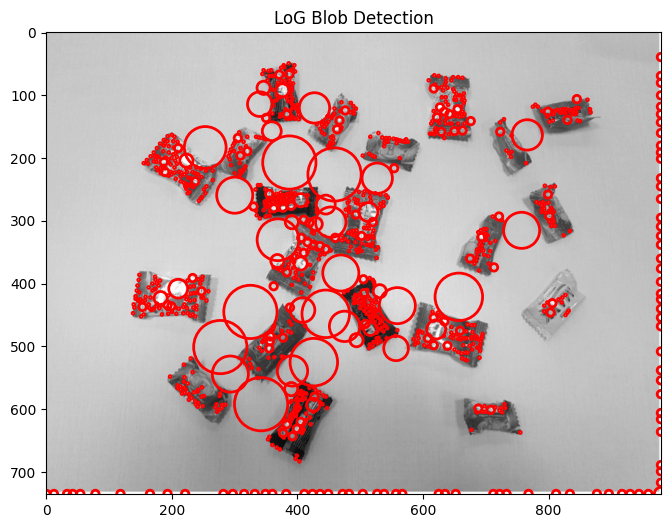

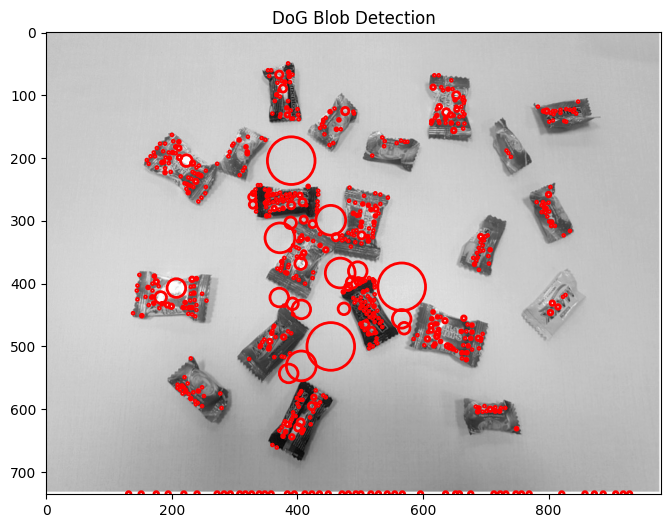

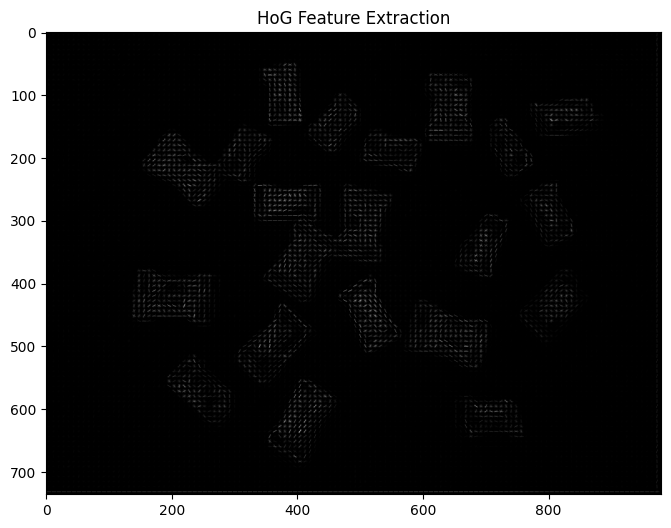

In [ ]:
#Task 01
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, hog
from skimage import color, exposure

# Load Image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

# LoG Blob Detection
def log_blob_detection(image):
    blobs_log = blob_log(image, max_sigma=30, num_sigma=10, threshold=0.1)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)  # Compute radii
    return blobs_log

# DoG Blob Detection
def dog_blob_detection(image):
    blobs_dog = blob_dog(image, max_sigma=30, threshold=0.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
    return blobs_dog

# HoG Feature Extraction
def hog_feature_extraction(image):
    image = color.rgb2gray(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image_rescaled

# Display results
def display_results(image, blobs, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image, cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    ax.set_title(title)
    plt.show()

# Load Image (Provide path or use an inbuilt image)
image_path = "sample.jpg"  # Change this to your image path
image = load_image(image_path)

# Apply Blob Detection Techniques
blobs_log = log_blob_detection(image)
display_results(image, blobs_log, "LoG Blob Detection")

blobs_dog = dog_blob_detection(image)
display_results(image, blobs_dog, "DoG Blob Detection")

# Apply HoG Feature Extraction
hog_image = hog_feature_extraction(image)
plt.figure(figsize=(8,6))
plt.imshow(hog_image, cmap='gray')
plt.title("HoG Feature Extraction")
plt.show()

Training AlexNet...
Epoch 1, Loss: 0.4722
AlexNet Training Time: 153.47 seconds
Accuracy: 88.69%
Training VGG16...
Epoch 1, Loss: 0.5036
VGG16 Training Time: 1093.28 seconds
Accuracy: 87.86%


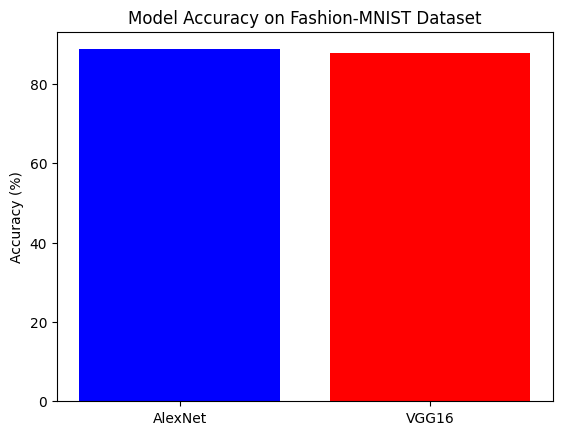

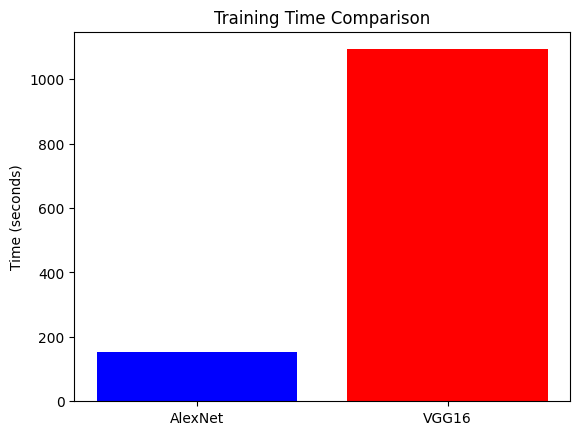

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

# Task 2: Image Classification on Fashion-MNIST

def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for AlexNet and VGG16
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

# Load Pretrained AlexNet and modify for Fashion-MNIST
def get_alexnet():
    model = torchvision.models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 10)  # Adjust for 10 classes
    return model

# Load Pretrained VGG16 and modify for Fashion-MNIST
def get_vgg16():
    model = torchvision.models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 10)  # Adjust for 10 classes
    return model

# Training function
def train_model(model, trainloader, criterion, optimizer, epochs=1, device='cuda'):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}')
    return model

# Evaluation function
def evaluate_model(model, testloader, device='cuda'):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

# Performance comparison
def compare_models():
    trainloader, testloader = get_data_loaders()

    models = {'AlexNet': get_alexnet(), 'VGG16': get_vgg16()}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    results = {}
    for name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        print(f'Training {name}...')
        start_time = time.time()
        trained_model = train_model(model, trainloader, criterion, optimizer, epochs=1, device=device)
        elapsed_time = time.time() - start_time
        print(f'{name} Training Time: {elapsed_time:.2f} seconds')
        accuracy = evaluate_model(trained_model, testloader, device=device)
        results[name] = {'accuracy': accuracy, 'time': elapsed_time}

    # Plot results
    plt.bar(results.keys(), [res['accuracy'] for res in results.values()], color=['blue', 'red'])
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy on Fashion-MNIST Dataset')
    plt.show()

    plt.bar(results.keys(), [res['time'] for res in results.values()], color=['blue', 'red'])
    plt.ylabel('Time (seconds)')
    plt.title('Training Time Comparison')
    plt.show()

# Run model comparison
compare_models()
